In [1]:
import itertools
import os
import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy.io as sio
from scipy import stats
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import KFold, LeaveOneOut, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, balanced_accuracy_score
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline

from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.geometry.spd_matrices import SPDMetricAffine
from IPython.display import display

# pyriemann import
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

# self package import
import dataloader
import bandpower
import preprocessing
import visualize
from plot_confusion_matrix import plot_confusion_matrix

# Ignore warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


INFO: Using numpy backend


# Cross validation

### Modify parameters

In [2]:
# Evaluation parameters
input_type = ['psd', 'bp', 'cov'][0]
data_folder = 'resting_ASR_ref'
label_formats = list(range(2,3))
low_freq, high_freq = list(range(3,50, 3)), list(range(4,51, 3))
n_splits = 5 if data_folder in ['bp_ica_only','resting_ASR','resting_ASR_ref'] else 10
average_regions = 1
reReference = False
# no-sw:　Without sliding window, only-sw: With sliding window only, sw-major-vote: With sliding window and majority vote
sliding_window = ['no-sw', 'only-sw', 'sw-major-vote'][2]
METRICS = ['acc', 'recall', 'precision', 'f1', 'balanced_acc']
METRIC_METHODS = [
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    balanced_accuracy_score
]
WINDOW_SIZE_RANGE = list(range(2*1000, 41*1000+1, 5000))

# model_names = ['naive', 'svm', 'xgboost', 'random_forest', 'lda']
# cv_modes = ['KFold', 'LOSO', 'LOO']
# # add_features = ['None', 'coherence', 'coherence_only']
# preprocess_methods = ['None', 'StdScale', 'PCAVar', 'L1select']
# imbalanced_methods = ['None', 'SMOTE', 'cost-sensitive']
model_names = ['lda']
cv_modes = ['KFold', 'LOSO', 'LOO']
add_features = ['None', 'coherence', 'coherence_only']
preprocess_methods = ['None', 'StdScale', 'PCAVar', 'L1select']
imbalanced_methods = ['None', 'SMOTE', 'cost-sensitive']


# Output configs
show_acc = False
output_cm = False
save_record = True
feature_folder = ''
folder_name = '{input}_{low_bound}_{high_bound}_classification_{data_folder}_{sliding_window}_label2'.format(
    input=input_type, low_bound=low_freq[0], high_bound=high_freq[-1], data_folder=data_folder, sliding_window=sliding_window)
if not os.path.exists('./results/'+folder_name):
    os.makedirs('./results/'+folder_name)
if feature_folder and not os.path.exists('./results/'+feature_folder):
    os.makedirs('./results/'+feature_folder)

'''
# Model for RMDM
model_names = ['rmdm']
add_features = ['None']
preprocess_methods = ['None']
imbalanced_methods = ['None', 'SMOTE']
'''



"\n# Model for RMDM\nmodel_names = ['rmdm']\nadd_features = ['None']\npreprocess_methods = ['None']\nimbalanced_methods = ['None', 'SMOTE']\n"

### Functions

In [3]:
def calculate_metrics(target, pred):
    # Return acc, precision, recall, f1, balanced acc
    
    return [method(target, pred) for method in METRIC_METHODS]
    

def augment_indices(indices, augment_size):
    """
    Augment indices to avoid sliding window contaminating training data in cross validation
    
    e.g. indices = [2, 4, 7], augment_size = 3
    return [6, 7, 8, 12, 13, 14, 21, 22, 23]
    """
    new_indices = []
    for index in indices:
        new_indices.extend(list(range(index*augment_size, (index+1)*augment_size)))
        
    return new_indices

def compress_outputs(outputs, compress_size):
    """
    Compress targets to reduce size of sliding window targets
    
    e.g. outputs = [1, 1, 1, 0, 0, 0, 1, 1, 1], compress_size = 3
    return [1, 0, 1]
    """
    return [outputs[i*compress_size] for i in range(len(outputs)//compress_size)]

def majority_vote(predictions, num_window):
    """
    Majority vote for predictions in sliding window
    
    e.g. predictions = [0,1,0, 1,1,1, 1,1,0, 0,0,1], window_size = 3
    return [0, 1, 1, 0]
    """
    vote_results = []
    for i in range(len(predictions)//num_window):
        vote_results.append(stats.mode(predictions[i*num_window:(i+1)*num_window]).mode[0])
        
    return np.array(vote_results)

### Run evaluation

In [4]:
for window_size in WINDOW_SIZE_RANGE:
    folder_name = 'majority_vote_new_welch_median/{input}_{low_bound}_{high_bound}_classification_{data_folder}_{sliding_window}_window-size={window_size}_label2'.format(
        input=input_type, low_bound=low_freq[0], high_bound=high_freq[-1], data_folder=data_folder, sliding_window=sliding_window, window_size=window_size)
    if not os.path.exists('./results/'+folder_name):
        os.makedirs('./results/'+folder_name)
    
    for label_format in label_formats:

        X, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
        data = preprocessing.StressData(X, Y, df_all)

        # Remove abnormal trials
        if ['rmdm'] in model_names:
            data.remove_abnormal_trials(tol=1e4)

        # Remove bad trials
        if label_format < 4 and data_folder=='rawdata':
            data.remove_trials()

        if reReference:
            data.reReference('CZ')

        if average_regions:
            data.avg_channels_into_regions(mode=average_regions)

        print('Class ratio - {class0}:{class1}'.format(
            class0 = np.bincount(data.labels)[0],
            class1 = np.bincount(data.labels)[1]
        ))

        # Augment data by sliding window
        if sliding_window != 'no-sw':
            num_window = data.sliding_window_augmentation(window_size=window_size)

        # Get coherence
        if 'coherence' in add_features or 'coherence_only' in add_features:
            low, high = [4, 7, 13], [7, 13, 30]
            coherence = data.get_coherence(low, high)

        # Transform into power
        low, high = low_freq, high_freq
        if input_type == 'psd':
            _, psds, freqs = bandpower.get_bandpower(data.EEG_list, low=low, high=high, dB_scale=True)

            psds = np.array(psds)
            idx = np.logical_and(freqs >= low[0], freqs <= high[-1])
            idx = idx.T   # (65,3)->(3,65)
            # psds = psds[..., freqs<high[-1]]
            # freqs = freqs[freqs<high[-1]]
            psds = psds[..., idx]
            freqs = freqs[idx]
            
            print('psds.shape: ', psds.shape)
            print('freqs.shape: ', freqs.shape)

            X = psds
            xaxis = np.array(freqs)
        elif input_type == 'bp':
            powers, _, freqs = bandpower.get_bandpower(data.EEG_list, low=low, high=high, dB_scale=True)

            X = powers
            xaxis = np.array(low)
        else:
            X = data.get_covariance()

        for model_name, cv_mode, added_feature, preprocess_name, imbalanced_method in itertools.product(model_names, cv_modes, add_features, preprocess_methods, imbalanced_methods):

            file_name = '%s/label%d_%s_%s_%s_%s_%s.csv'%(folder_name, label_format, model_name, cv_mode, added_feature, preprocess_name, imbalanced_method)
            description = 'Data: %s, Label: %d, Model: %s, CV mode: %s, Added features: %s, Preprocess: %s, Imblanced: %s'%(
                data_folder, label_format, model_name, cv_mode, added_feature, preprocess_name, imbalanced_method)
            print(description)

            inputs = np.array(X)
            if input_type != 'cov':
                inputs = inputs.reshape((len(inputs),-1))

            # Add additional features
            if added_feature == 'coherence':
                inputs = np.concatenate((inputs, coherence), axis=1)
            elif added_feature == 'coherence_only':
                inputs = coherence

            # Set split folds for cross validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=23)
            loo = LeaveOneOut()
            S = data.df_all['subject'].values
            data_to_split = data.sample_indices if (sliding_window!='no-sw') else list(range(len(inputs)))
            if cv_mode == 'KFold':
                folds = kf.split(data_to_split)
            elif cv_mode == 'LOO':
                folds = loo.split(data_to_split)
            elif cv_mode == 'LOSO':
                folds = np.unique(S)    

            folds = list(folds)

            md = {
                'train': {metric: [0]*len(folds) for metric in METRICS},
                'val': {metric: [0]*len(folds) for metric in METRICS},
                'avg': {metric: 0 for metric in METRICS},
            }
            num_val_list = []
            chance_list = []
            fold_name_list = []

            train_confusion = np.zeros((2,2))
            val_confusion = np.zeros((2,2))
            if added_feature != 'coherence_only':
                if preprocess_name == 'L1select':
                    selected_features = {region:[] for region in ['F','LT','C','RT','P','O']}
                else:
                    selected_features = {region: np.zeros(len(xaxis)) for region in ['F','LT','C','RT','P','O']}    # For XGB feature importances
                    all_feature_importances = {region: np.zeros((len(folds), len(xaxis))) for region in ['F','LT','C','RT','P','O']}
            if added_feature in ['coherence','coherence_only']:
                selected_features = {'coherence': []}

            if show_acc:
                print('Sub  \t Chance\t | Train | Val')
            for i_fold, fold in enumerate(folds):
                if cv_mode in ['KFold','LOO']:
                    train_indices = fold[0]
                    val_indices = fold[1]
                else:
                    subID = fold
                    train_indices = np.where(S!=subID)[0]
                    val_indices = np.where(S==subID)[0]

                # Augment train_indices and val_indices if data is augmented with sliding window
                if sliding_window != 'no-sw':
                    train_indices = augment_indices(train_indices, num_window)
                    val_indices = augment_indices(val_indices, num_window)

                X_train, Y_train = inputs[train_indices,...], data.labels[train_indices]
                X_val, Y_val = inputs[val_indices,...], data.labels[val_indices]

                # Preprocessing features
                if preprocess_name == 'StdScale':
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)
                elif preprocess_name == 'L1select':
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)
                    X_train, X_val, sel_ = preprocessing.select_features(X_train, X_val, Y_train)

                    if 'L1' in feature_folder:

                        if added_feature != 'coherence_only':
                            # Plot L1 selected features
                            fig, axs = plt.subplots(2, 3, figsize=(10,6))
                            for i_channel in range(6):

                                row, col = i_channel//3, i_channel%3

                                coef = sel_.estimator_.coef_[0,i_channel*len(xaxis):(i_channel+1)*len(xaxis)]

                                axs[row][col].plot(xaxis, coef)
                                axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

                                selected_features[data.df_all.loc[0,'channels'][i_channel]].append(list(xaxis[np.where(coef!=0)[0]]))

                            fig.suptitle('L1 coefficients of fold %d'%(i_fold))
                            fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
                            fig.text(0.05, 0.5, 'Coefficients', va='center', rotation='vertical')
                            fig.savefig('./results/{L1_feature_folder}/{i_fold}.png'.format(
                                L1_feature_folder=feature_folder,i_fold=i_fold))

                        if added_feature == 'coherence':
                            coef = sel_.estimator_.coef_[0, 6*len(xaxis):]
                            selected_features[added_feature].append(list(np.where(coef!=0)[0]))

                        if added_feature == 'coherence_only':
                            coef = sel_.estimator_.coef_[0]
                            selected_features['coherence'].append(list(np.where(coef!=0)[0]))

                elif preprocess_name in ['PCAVar', 'PCAL1select', 'SparsePCA']:
                    if preprocess_name == 'PCAVar':
                        n_components = 0.9
                    elif preprocess_name == 'PCAL1select':
                        n_components = np.min(X_train.shape)
                    elif preprocess_name == 'SparsePCA':
                        n_components = 10

                    scaler, pca = StandardScaler(), PCA(n_components=n_components)
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)

                    X_train = pca.fit_transform(X_train)
                    X_val = pca.transform(X_val)

                    if preprocess_name == 'PCAL1select':
                        X_train, X_val, _ = preprocessing.select_features(X_train, X_val, Y_train)

                # Resample training data
                if imbalanced_method == 'SMOTE':
                    sm = SMOTE(random_state=23)
                    if input_type == 'cov':
                        num_channels = X_train.shape[1]
                        X_train = X_train.reshape((len(X_train),-1))
                        X_train, Y_train = sm.fit_resample(X_train, Y_train)
                        X_train = X_train.reshape((len(X_train), num_channels, num_channels))
                    else:
                        X_train, Y_train = sm.fit_resample(X_train, Y_train)


                # Train classifier
                num_neg, num_pos = tuple(np.bincount(Y_train))

                if model_name == 'svm':
                    if imbalanced_method == 'cost-sensitive':
                        clf = svm.SVC(class_weight='balanced')
                    else:
                        clf = svm.SVC()
                elif model_name == 'xgboost':
                    if imbalanced_method == 'cost-sensitive':
                        clf = xgb.XGBClassifier(scale_pos_weight=num_neg/num_pos)
                    else:
                        clf = xgb.XGBClassifier()
                elif model_name == 'naive':
                    if imbalanced_method == 'cost-sensitive':
                        clf = GaussianNB(priors = [num_pos/len(Y_train), num_neg/len(Y_train)])
                    else:
                        clf = GaussianNB()
                elif model_name == 'random_forest':
                    if imbalanced_method == 'cost-sensitive':
                        clf = RandomForestClassifier(max_depth=2, class_weight='balanced', random_state=23)
                    else:
                        clf = RandomForestClassifier(max_depth=2)
                elif model_name == 'rmdm':
                    clf = MDM(metric=dict(mean='riemann', distance='riemann'))
                elif model_name == 'lda':
                    if imbalanced_method == 'cost-sensitive':
                        clf = LinearDiscriminantAnalysis(priors = [num_pos/len(Y_train), num_neg/len(Y_train)])
                    else:
                        clf = LinearDiscriminantAnalysis()

                clf.fit(X_train, Y_train)

                # Test classifier
                pred_train = clf.predict(X_train)
                pred_val = clf.predict(X_val)

                # Majority vote for sliding window case
                if sliding_window == 'sw-major-vote':
                    pred_train = majority_vote(pred_train, num_window)
                    pred_val = majority_vote(pred_val, num_window)
                    Y_train= compress_outputs(Y_train, num_window)
                    Y_val = compress_outputs(Y_val, num_window)

                train_confusion += confusion_matrix(Y_train, pred_train, labels=[0,1])
                val_confusion += confusion_matrix(Y_val, pred_val, labels=[0,1])

                [md['train']['acc'][i_fold], md['train']['recall'][i_fold], md['train']['precision'][i_fold],
                     md['train']['f1'][i_fold], md['train']['balanced_acc'][i_fold]] = calculate_metrics(Y_train, pred_train)
                [md['val']['acc'][i_fold], md['val']['recall'][i_fold], md['val']['precision'][i_fold],
                     md['val']['f1'][i_fold], md['val']['balanced_acc'][i_fold]] = calculate_metrics(Y_val, pred_val)

                fold_name = 'Fold %d'%(i_fold) if cv_mode in ['KFold','LOO'] else 'Sub %d'%(subID)
                chance = np.sum(Y_train)/len(Y_train)
                chance = (1-chance) if chance<0.5 else chance

                num_val_list.append(len(Y_val))
                fold_name_list.append(fold_name)
                chance_list.append(chance)

                if show_acc:
                    print('%s\t %.1f%%\t | %.1f%% | %.1f%%'%(fold_name, chance*100, md['train']['acc'][i_fold]*100, md['val']['acc'][i_fold]*100))

                if output_cm:
                    fileName_cm = './results/' + file_name[:file_name.find('.')] + '_' + fold_name
                    plot_confusion_matrix(Y_train, pred_train, np.array(['Normal','Increase']), 
                                         fileName='%s_train.png'%(fileName_cm), title=fold_name)
                    plot_confusion_matrix(Y_val, pred_val, np.array(['Normal','Increase']), 
                                         fileName='%s_val.png'%(fileName_cm), title=fold_name)

                if 'XGB' in feature_folder:
                    # Plot L1 selected features
                    fig, axs = plt.subplots(2, 3, figsize=(10,6))
                    for i_channel in range(6):

                        region = data.df_all.loc[0,'channels'][i_channel]
                        row, col = i_channel//3, i_channel%3

                        coef = clf.feature_importances_[i_channel*len(xaxis):(i_channel+1)*len(xaxis)]

                        axs[row][col].plot(xaxis, coef)
                        axs[row][col].set_title(data.df_all.loc[0,'channels'][i_channel])

                        all_feature_importances[region][i_fold] = coef
                        all_feature_importances['freq'] = xaxis
                        selected_features[region] += coef / len(folds)

                    fig.suptitle('XGBoost feature importances of fold %d'%(i_fold))
                    fig.text(0.5, 0.05, 'Frequency (Hz)', ha='center')
                    fig.text(0.05, 0.5, 'Feature Imporances', va='center', rotation='vertical')
                    fig.savefig('./results/{folder}/{i_fold}.png'.format(
                        folder=feature_folder,i_fold=i_fold))

            tp, fp = val_confusion[1,1], val_confusion[0,1]
            tn, fn = val_confusion[0,0], val_confusion[1,0]

            md['avg']['acc'] = (tp+tn) / (tp+tn+fp+fn)
            md['avg']['recall'] = tp / (tp+fn) if tp+fn!=0 else 0
            md['avg']['precision'] = tp / (tp+fp) if tp+fp!=0 else 0
            md['avg']['f1'] = 2 / (1/md['avg']['recall']+1/md['avg']['precision']) if md['avg']['recall']!=0 and md['avg']['precision']!=0 else 0
            md['avg']['balanced_acc'] = ((tp/(tp+fn)) + (tn/(tn+fp))) / 2

            if show_acc:
                print('Average val acc: %.1f%%'%(md['avg']['acc']*100))

            # Save result as csv file
            dict_result = {description: fold_name_list, 'Chance_train_acc': chance_list}
            for metric in METRICS:
                dict_result['Train_'+metric] = md['train'][metric]
                dict_result['Val_'+metric] = md['val'][metric]
            df_result = pd.DataFrame(dict_result)
            df_result.loc[len(df_result),description] = 'Average'
            for metric, value in md['avg'].items():
                df_result.loc[len(df_result)-1, 'Val_'+metric] = value

            if save_record:
                df_result.to_csv('./results/%s'%(file_name))

Load data from .mat files...


/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 2618 (34x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (2618, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCA

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 693 (9x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (693, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 385 (5x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (385, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 308 (4x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (308, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 231 (3x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (231, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 154 (2x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (154, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 154 (2x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (154, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAV

/home/hundredball/anaconda3/envs/classroom/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Remove trials due to lack of regions
Remove trials:
Number: 4, Session: 20141215, Subject: 1, Label: 1
Number: 7, Session: 20141006, Subject: 2, Label: 0
Number: 12, Session: 20150112, Subject: 2, Label: 0
Number: 16, Session: 20141103, Subject: 3, Label: 0
Number: 23, Session: 20141103, Subject: 4, Label: 0
Number: 28, Session: 20140929, Subject: 5, Label: 0
Number: 29, Session: 20141013, Subject: 5, Label: 0
Number: 33, Session: 20141222, Subject: 5, Label: 0
Number: 60, Session: 20141218, Subject: 10, Label: 1
Number: 61, Session: 20141223, Subject: 10, Label: 1
Number: 62, Session: 20141014, Subject: 11, Label: 0
Number: 70, Session: 20141016, Subject: 12, Label: 0
Number: 102, Session: 20141023, Subject: 17, Label: 0
Number: 103, Session: 20141127, Subject: 17, Label: 1
Number: 104, Session: 20141211, Subject: 17, Label: 1
Class ratio - 61:16
Sliding window augments number of data from 77 to 77 (1x)
Calculating the bandpower of time-series data...


/home/hundredball/Desktop/Project_Stress/Classroom_stress/bandpower.py:74: RuntimeWarning: divide by zero encountered in log10
  sample_powers = 10*np.log10(sample_powers)


psds.shape:  (77, 6, 31)
freqs.shape:  (31,)
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: None, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: SMOTE
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: StdScale, Imblanced: cost-sensitive
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVar, Imblanced: None
Data: resting_ASR_ref, Label: 2, Model: lda, CV mode: KFold, Added features: None, Preprocess: PCAVa

# Save XGBoost feature importance or L1 selected features

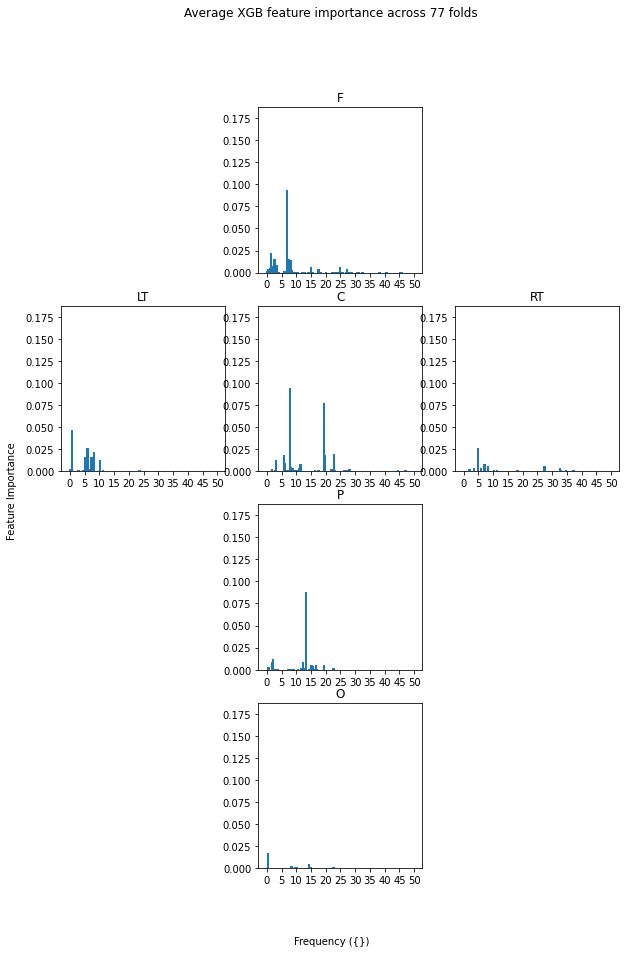

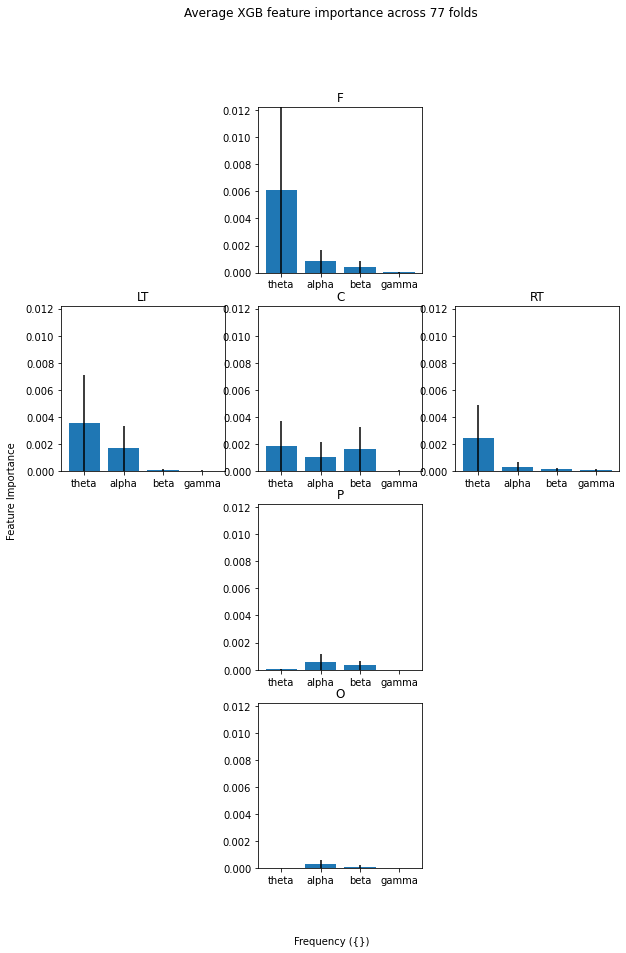

In [4]:
# L1: Features selected by L1 regression, save csv for further analysis in data_analysis.ipynb
# XGBoost: The gain type shows the average gain across all splits where feature was used, save mat for topoplot in topoplot_features.m
if 'L1' in feature_folder:
    df = pd.DataFrame.from_dict(selected_features)
    df.to_csv('results/{feature_folder}/select.csv'.format(feature_folder=feature_folder))
elif 'XGB' in feature_folder:
    bands = {'theta':(4,7), 'alpha':(8,13), 'beta':(14,30), 'gamma':(31,50)}
    regions = ['F','LT','C','RT','P','O']
    bandpower_regions = {region: np.zeros((len(all_feature_importances['F']), len(bands))) for region in regions}
    bandpower_regions['freq'] = bands.keys()
    bandpowers = {}
    for i_band, band in enumerate(bands.keys()):
        bandpowers[band] = []
        low, high = bands[band][0], bands[band][1]

        for i_region, region in enumerate(regions):
            
            # Average feature importances in each band
            idx = np.logical_and(xaxis >= low, xaxis <= high)
            
            bandpowers[band].append(np.mean(selected_features[region][idx]))
            bandpower_regions[region][:, i_band] = np.mean(all_feature_importances[region][:, idx], axis=1)
    
    # Save feature with feature importances more than zero as csv file
    selected_freq = {}
    for key, value in selected_features.items():
        selected_freq[key] = [list(xaxis[np.where(selected_features[key]>0)[0]])]
    df_selected_freq = pd.DataFrame.from_dict(selected_freq)
    df_selected_freq.to_csv('{folder}/XGB_selected_freq.csv'.format(folder='results/'+feature_folder))
        
    # Save as mat file
    sio.savemat('{folder}/XGB_feature_importances.mat'.format(folder='results/'+feature_folder), bandpowers)
    
    # Save bandpower as json file
    with open('{}/XGB_feature_importances_bandpower.json'.format('results/'+feature_folder), 'w') as f:
        json.dump(bandpowers, f)
        
    # Plot feature importance in Hz
    visualize.plot_XGB_feature_importance(all_feature_importances, feature_folder, xaxis='Hz')
    
    # Plot feature importance in band
    visualize.plot_XGB_feature_importance(bandpower_regions, feature_folder, xaxis='band', error_bar=True)
    

# Find highest performance among multiple csv files

In [16]:
import glob
import itertools

data_name = 'test_bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2'
save = True
output_path = './results/record_new.csv'
main_metric = 'Val_balanced_acc'    # Main metric for comparison

val_methods = ['KFold', 'LOO', 'LOSO']
list_result = []
list_result.append('{folder}_{metric}'.format(folder=data_name, metric=main_metric))
for val_method in val_methods:
    
    # Modify here to compare different files
    """
    files = glob.glob(
        './results/{folder}/label2_*_{val}_{coherence}_*_{imbalance}.csv'.format(
            folder=data_name, val=val_method, coherence='None', imbalance='SMOTE'
        )
    )
    """
    files = glob.glob('./results/majority_vote/*/*{}*.csv'.format(val_method))
    max_metric, max_file = 0, ''

    for file in files:

        df = pd.read_csv(file)
        metric = df.loc[len(df)-1, main_metric]

        if metric>=max_metric:
            max_metric, max_file = metric, file

    df = pd.read_csv(max_file)
    print(max_file)
    for metric in METRICS:
        print('Best {metric}: {value:5.3f}'.format(metric=metric, value=df.loc[len(df)-1,'Val_'+str(metric)])) 
    # Append model name
    list_result.append(max_file.split('/')[-1])   
    
    # Append metrics of the model
    for metric in ['Val_'+metric for metric in METRICS]:
        list_result.append(df.loc[len(df)-1, metric])
        
if save:
    record_exist = os.path.exists(output_path)
    if record_exist:
        df_record = pd.read_csv(output_path, index_col=0)
    
    if not record_exist or len(df_record) == 0:
        df_record = pd.DataFrame(
            [list_result],
            columns = ['input_target'] + [
            '{val}_{metric}'.format(val=val,metric=metric) for val, metric in list(
                itertools.product(val_methods,['model']+METRICS)
            )
        ])
    else:
        df_record.loc[len(df_record)] = list_result
    df_record.to_csv(output_path)


./results/majority_vote/bp_1_50_classification_resting_ASR_ref_sw-major-vote_window-size=22000_label2/label2_naive_KFold_coherence_L1select_cost-sensitive.csv
Best acc: 0.688
Best recall: 0.812
Best precision: 0.382
Best f1: 0.520
Best balanced_acc: 0.734
./results/majority_vote/bp_1_50_classification_resting_ASR_ref_sw-major-vote_window-size=27000_label2/label2_naive_LOO_coherence_L1select_cost-sensitive.csv
Best acc: 0.766
Best recall: 0.750
Best precision: 0.462
Best f1: 0.571
Best balanced_acc: 0.760
./results/majority_vote/bp_1_50_classification_resting_ASR_ref_sw-major-vote_window-size=27000_label2/label2_naive_LOSO_coherence_L1select_cost-sensitive.csv
Best acc: 0.740
Best recall: 0.750
Best precision: 0.429
Best f1: 0.545
Best balanced_acc: 0.744


# Plot performance of model with varying size of time window

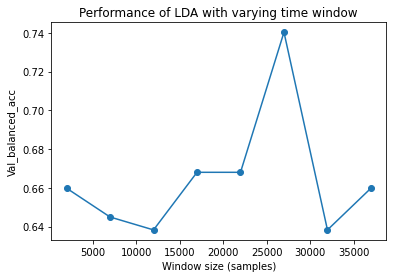

In [5]:
file_patterns = './results/majority_vote_new_welch_median/*/label2_lda_LOO_None_L1select_SMOTE.csv'
files = glob.glob(file_patterns)
files.sort()

dict_performance = {}

main_metric = 'Val_balanced_acc'    # Main metric for comparison
for file in files:
    index_equal = file.find('=')
    index_underline = file[index_equal:].find('_')    # first underline after equal
    window_size = int(file[index_equal+1: index_equal+index_underline])
    
    df = pd.read_csv(file)
    metric = df.loc[len(df)-1, main_metric]
    
    dict_performance[window_size] = metric
    
list_window_size = sorted(dict_performance.keys())
list_performance = [dict_performance[window_size] for window_size in list_window_size]
    
plt.plot(list_window_size, list_performance, '-o')
plt.title('Performance of LDA with varying time window')
plt.xlabel('Window size (samples)')
plt.ylabel(main_metric)

folder = '/'.join(file_patterns.split('/')[:3])
plt.savefig(os.path.join(folder, 'performance_time_window.png'))

# Plot grouped bar chart of metrics of best preprocessing for each model

./results/bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2/label2_naive_LOO_None_None_SMOTE.csv
Best acc: 0.506
Best recall: 0.688
Best precision: 0.250
Best f1: 0.367
./results/bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2/label2_svm_LOO_None_None_SMOTE.csv
Best acc: 0.792
Best recall: 0.562
Best precision: 0.500
Best f1: 0.529
./results/bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2/label2_random_forest_LOO_None_PCAVar_SMOTE.csv
Best acc: 0.766
Best recall: 0.375
Best precision: 0.429
Best f1: 0.400
./results/bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2/label2_xgboost_LOO_None_None_SMOTE.csv
Best acc: 0.805
Best recall: 0.250
Best precision: 0.571
Best f1: 0.348


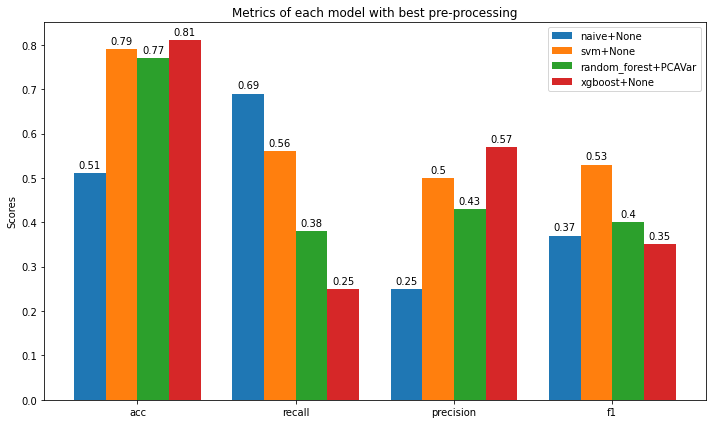

In [14]:
import glob
import itertools

data_name = 'bp_1_50_classification_resting_ASR_ref_sw-major-vote_label2'
save = True
main_metric = 'Val_f1'    # Main metric for comparison

# Find best preprocessing for each model
models = ['naive', 'svm', 'random_forest', 'xgboost']
metrics = ['acc', 'recall', 'precision', 'f1']
metric_dict = {model: [] for model in models}
preprocess_list = []

for model in models:
    
    # Modify here to compare different files
    files = glob.glob(
        './results/{folder}/label2_{model}_LOO_None_*_SMOTE.csv'.format(
            folder=data_name, model=model
        )
    )
    max_metric, max_file = 0, ''

    for file in files:

        df = pd.read_csv(file)
        metric = df.loc[len(df)-1, main_metric]

        if metric>max_metric:
            max_metric, max_file = metric, file

    preprocess_list.append(max_file.split('_')[-2])
    df = pd.read_csv(max_file)
    
    print(max_file)
    for metric in metrics:
        value = df.loc[len(df)-1,'Val_'+str(metric)]
        print('Best {metric}: {value:5.3f}'.format(metric=metric, value=value)) 
        metric_dict[model].append(round(value,2))

# Plot bar chart
width = 0.2  # the width of the bars
x = np.arange(len(metrics))   # label locations

fig, ax = plt.subplots(figsize=(10,6))
width_list = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]
rects = [ax.bar(x+width_list[i], metric_dict[model], width, label='{model}+{pre}'.format(model=model, pre=preprocess_list[i])) 
         for i, model in enumerate(models)]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Metrics of each model with best pre-processing')
ax.set_xticks(x, metrics)
ax.legend()

for i in range(len(metrics)):
    ax.bar_label(rects[i], padding=3)

fig.tight_layout()
fig.savefig('./results/{folder}/performance_{data_name}_{main_metric}.png'.format(
    folder=data_name, data_name=data_name, main_metric=main_metric))

# K-Fold Cross Validation for hyperparameter tuning

In [35]:
def get_pipeline_parameters(model):
    
    if model == 'svm':
        pipeline = Pipeline(
            [
                ('scale',StandardScaler()),
                ('select_features',SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))),
                ('resample',SMOTE(random_state=23)),
                ('clf',svm.SVC())
            ]
        )
        parameters = {
            'clf__C' : np.linspace(0.1, 30, 300),
            'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
        }
        name_parameters = ['C', 'kernel']
    elif model == 'random_forest':
        pipeline = Pipeline(
            [
                ('resample',SMOTE(random_state=23)),
                ('clf',RandomForestClassifier())
            ]
        )
        parameters = {
            'clf__n_estimators' : np.linspace(10,100,10).astype('int'),
            'clf__max_depth' : np.linspace(1,100,10).astype('int')
        }
        name_parameters = ['n_estimators', 'max_depth']
        
    return pipeline, parameters, name_parameters

In [36]:
label_format = 4
data_folder = 'rest'

signals, Y, df_all = dataloader.read_data(label_format=label_format, data_folder=data_folder)
data = preprocessing.StressData(signals, Y, df_all)
    
# Remove bad trials
if label_format < 4:
    data.remove_trials()

# Average into regions
data.avg_channels_into_regions(mode=1)

# Transform into power
low, high = list(range(1,50)), list(range(2,51))
powers, psds, freqs = bandpower.get_bandpower(data.EEG_list, 1000, low=low, high=high, dB_scale=True)
powers = np.array(powers).reshape((len(powers),-1))
psds = np.array(psds)
psds = psds[...,freqs<50].reshape((len(psds),-1))
freqs = freqs[freqs<50]

X, Y = psds, data.labels

model = 'random_forest'
pipeline, parameters, name_parameters = get_pipeline_parameters(model)

scores = ['accuracy', 'recall', 'precision', 'f1']
cv = KFold(n_splits=10, shuffle=True, random_state=23)

random_cv = RandomizedSearchCV(pipeline, parameters, n_iter=100, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)
grid_cv = GridSearchCV(pipeline, parameters, cv=cv, scoring=scores, refit='f1', n_jobs=-1, verbose=3, return_train_score=True)

Load data from .mat files...


/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hundredball/anaconda3/envs/Math24_new/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Calculating the bandpower of time-series data...
freqs:  [0.000e+00 2.000e-01 4.000e-01 ... 4.996e+02 4.998e+02 5.000e+02]


In [37]:
grid_cv.fit(X, Y)

print('Best Parameters: ', grid_cv.best_params_)
print('Best f1 scores: ', grid_cv.best_score_)
print('Best recall: ', np.max(grid_cv.cv_results_['mean_test_recall']))
print('Best precision: ', np.max(grid_cv.cv_results_['mean_test_precision']))
print('Best accuracy: ', np.max(grid_cv.cv_results_['mean_test_accuracy']))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:  1.0min remaining:    0.4s


Best Parameters:  {'clf__max_depth': 1, 'clf__n_estimators': 20}
Best f1 scores:  0.55
Best recall:  0.65
Best precision:  0.6
Best accuracy:  0.6833333333333333


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


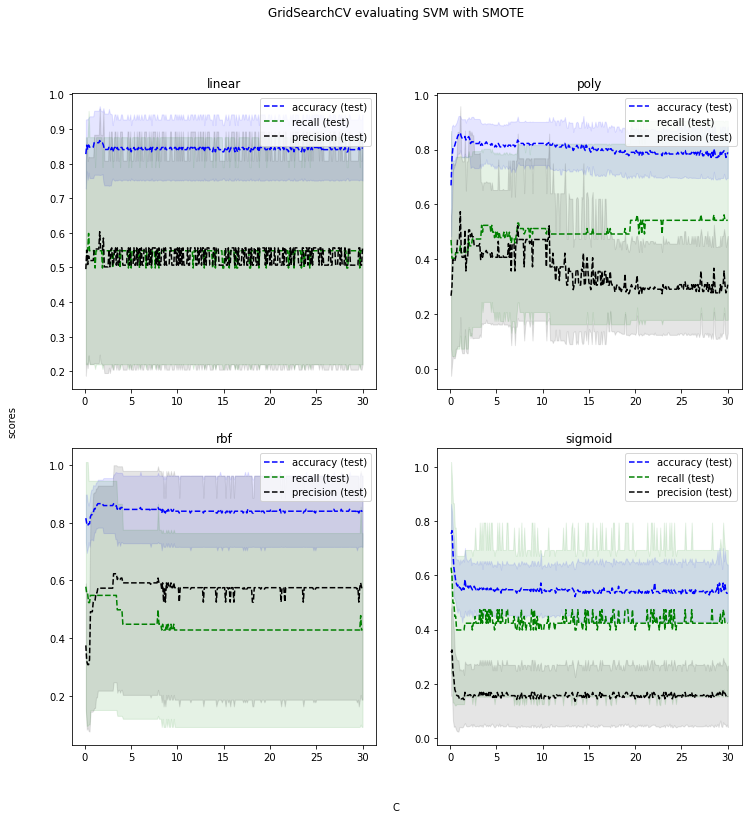

In [4]:
# Plot results for svm
fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('GridSearchCV evaluating %s with SMOTE'%(model))
fig.text(0.5, 0.05, 'C', ha='center')
fig.text(0.05, 0.5, 'scores', va='center', rotation='vertical')
X_axis = np.array(results['param_clf__%s'%(name_parameters[0])].data, dtype=float)[::4]

for i_plot, kernel in enumerate(parameters['clf__%s'%(name_parameters[1])]):
    
    row, col = i_plot//2, i_plot%2
    
    for scorer, color in zip(scores, ['b','g','k']):
        
        for sample, style in (('train','-'), ('test','--')):
            
            if sample == 'train':
                continue
            
            sample_score_mean = results['mean_%s_%s'%(sample, scorer)][i_plot::4]
            sample_score_std = results['std_%s_%s'%(sample, scorer)][i_plot::4]

            axs[row,col].fill_between(X_axis, sample_score_mean+sample_score_std, sample_score_mean-sample_score_std,
                                      alpha=0.1 if sample=='test' else 0, color=color)
            axs[row,col].plot(X_axis, sample_score_mean, style, color=color,
                              alpha=1 if sample=='test' else 0.7, label='%s (%s)'%(scorer, sample))
            
            axs[row, col].legend()
            axs[row, col].set_title(kernel)

In [2]:
'''
# Reset record.csv
keys = {}
keys['input_target'] = []
for val_method in ['KFold', 'LOO', 'LOSO']:
    for metric in ['model', 'accuracy', 'recall', 'precision', 'f1']:
        keys[val_method+'_'+metric] = []

df = pd.DataFrame(keys)
df.to_csv('./results/record.csv')
'''

# Classification for IC PSD

In [12]:
# Define process
PREPROCESS = ['None', 'StdScale', 'PCAVar', 'StdScale+L1Select']
PREPROCESS_METHODS = {
    'StdScale': [StandardScaler()],
    'PCAVar': [PCA(n_components=0.9)],
    'StdScale+L1Select': [StandardScaler(), SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))],
}

RESAMPLE = ['None', 'SMOTE']
RESAMPLE_METHODS = {
    'SMOTE': SMOTE(random_state=23)
}

MODEL_NAMES = ['naive', 'svm', 'lda', 'xgboost', 'random_forest']
MODELS = {
    'svm': svm.SVC(),
    'naive': GaussianNB(),
    'lda': LinearDiscriminantAnalysis(),
    'xgboost': xgb.XGBClassifier(eval_metric='error'),
    'random_forest': RandomForestClassifier(),
}

RECORD_SELECT_FEATURES = True
PREPROCESS = ['StdScale+L1Select']
RESAMPLE = ['SMOTE']
MODEL_NAMES = ['lda']

METRICS = ['accuracy', 'recall', 'precision', 'f1', 'balanced_accuracy']
METRIC_METHODS = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score,
    'balanced_accuracy': balanced_accuracy_score
}

# Frequency from 0-49 Hz
SELECT_FREQS = list(range(0, 50))
VALIDATION = ['KFold', 'LOSO', 'LOO'][2]
NUM_FOLDS = {
    'KFold': 5,
    'LOSO': 18,
    'LOO': 92
}[VALIDATION]
RESULT_FOLDER = './results/results_IC_PSD_{}_{}-{}'.format(VALIDATION, SELECT_FREQS[0], SELECT_FREQS[-1])

for folder in ['images', 'json', 'features']:
    path = os.path.join('results', RESULT_FOLDER, folder)
    if not os.path.isdir(path):
        os.makedirs(path)

In [16]:
X_train_list, Y_train_list, X_val_list, Y_val_list = [], [], [], []
if RECORD_SELECT_FEATURES:
    select_features = []

if VALIDATION == 'LOSO':
    psd_data, targets, subject_ids = dataloader.read_IC_PSD_LOSO('./data/icawm_allCh.mat', './data/firstsem_summary.csv')
elif VALIDATION == 'LOO':
    psd_data, targets, channels = dataloader.read_IC_PSD_LOO('./data/subset_channel/ch_power_asr.mat')

for i_pipe, (preprocess, resample, model_name) in enumerate(itertools.product(PREPROCESS, RESAMPLE, MODEL_NAMES)):

    # Set up pipeline
    pipeline = []
    if preprocess != 'None':
        preprocess_method = PREPROCESS_METHODS[preprocess]
        for i, prep_element in enumerate(preprocess_method):
            pipeline.append(('preprocess'+str(i), prep_element))

    if resample != 'None':
        pipeline.append(('resample', RESAMPLE_METHODS[resample]))

    pipeline.append(('model', MODELS[model_name]))
    pipeline = Pipeline(pipeline)

    # results = {x: [] for x in ['preprocess', 'resample', 'model']+['{}_{}'.format(phase, metric) for phase, metric in itertools.product(['train','val'],METRICS)]}
    results = {'preprocess': preprocess, 'resample': resample, 'model_name': model_name}
    [Y_train_array, Y_val_array, pred_train_array, pred_val_array] = [
        np.array([]) for _ in range(4)]

    for i_fold in range(NUM_FOLDS):

        # Read data
        if VALIDATION == 'LOSO':
            X_train, Y_train, X_val, Y_val = dataloader.split_by_subjects(psd_data, targets, subject_ids, i_fold+1)
        elif VALIDATION == 'LOO':
            if i_fold == 0:
                # first session is used as the IC projection, so it shouldn't be used as test data
                continue
            X_train, Y_train, X_val, Y_val = dataloader.split_by_samples(psd_data, targets, i_fold)
        else:
            X_train, Y_train, X_val, Y_val = dataloader.read_IC_PSD('./data/ICA_5folds/icawm_allCh_fold{}.mat'.format(i_fold+1))

        if len(X_val) == 0:
            continue
    
        [X_train, X_val] = [x[:, SELECT_FREQS, :] for x in [X_train, X_val]]

        # Flatten data
        [X_train, X_val] = [x.reshape(len(x), -1) for x in [X_train, X_val]]

        fold_name = 'fold {}'.format(i_fold+1)
        results[fold_name] = {}

        # Train model
        pipeline.fit(X_train, Y_train)
        
        # Record select features
        if RECORD_SELECT_FEATURES:
            select_features.append(pipeline.steps[1][1].estimator_.coef_[0])
        
        # Test model
        pred_train = pipeline.predict(X_train)
        pred_val = pipeline.predict(X_val)

        # Record results
        for metric in METRICS:
            results[fold_name]['{}_{}'.format('train',metric)] = METRIC_METHODS[metric](Y_train, pred_train)
            results[fold_name]['{}_{}'.format('val',metric)] = METRIC_METHODS[metric](Y_val, pred_val)

        Y_train_array = np.concatenate((Y_train_array, Y_train))
        Y_val_array = np.concatenate((Y_val_array, Y_val))
        pred_train_array = np.concatenate((pred_train_array, pred_train))
        pred_val_array = np.concatenate((pred_val_array, pred_val))

    # Record average results across folds
    for metric in METRICS:
        results['avg_train_{}'.format(metric)] = METRIC_METHODS[metric](Y_train_array, pred_train_array)
        results['avg_val_{}'.format(metric)] = METRIC_METHODS[metric](Y_val_array, pred_val_array)

    # Save files
    file_name = '{}_{}_{}'.format(preprocess, resample, model_name)
    image_path = os.path.join(RESULT_FOLDER, 'images', '{}_cm.png'.format(file_name))
    plot_confusion_matrix(Y_val_array.astype('int'), pred_val_array.astype('int'), classes=np.array(['Normal', 'Increase']), fileName=image_path)

    result_path = os.path.join(RESULT_FOLDER, 'json', '{}_metrics.json'.format(file_name))
    with open(result_path, 'w') as f:
        json.dump(results, f, indent=4)


(92, 50, 30)


In [30]:
# Find best model
compare_metric = 'balanced_accuracy'
best_path, best_metric, best_result = '', 0, {}

for file_path in glob.glob(os.path.join('results', RESULT_FOLDER, 'json', '*.json')):
    with open(file_path, 'r') as f:
        result = json.load(f)
    
    metric = result['avg_val_{compare_metric}'.format(compare_metric=compare_metric)]
    if metric > best_metric:
        best_metric = metric
        best_result = result
        best_path = file_path
        
best_model = os.path.split(best_path)[-1]
print('Best model: ', best_model)
for metric in METRICS:
    print('{}: {}'.format(metric, best_result['avg_val_'+metric]))
    
# Save results in record
record_file_path = './results/record_IC_PSD.csv'
if os.path.isfile(record_file_path):
    record_df = pd.read_csv(record_file_path, index_col=0)
else:
    record_dict = {metric: [] for metric in METRICS}
    record_df = pd.DataFrame.from_dict(record_dict)

record_df.loc[len(record_df), 'val'] = VALIDATION
record_df.loc[len(record_df)-1, 'best_model'] = best_model
record_df.loc[len(record_df)-1, 'frequecy'] = '{}-{}'.format(SELECT_FREQS[0], SELECT_FREQS[-1])
for metric in METRICS:
    record_df.loc[len(record_df)-1, metric] = best_result['avg_val_' + metric]
    
record_df.to_csv(record_file_path)

Best model:  StdScale+L1Select_SMOTE_lda_metrics.json
accuracy: 0.8241758241758241
recall: 0.6
precision: 0.6
f1: 0.6
balanced_accuracy: 0.7436619718309859


## Analyze L1 select features

In [17]:
try:
    nonzero_features = np.zeros(select_features[0].shape)
except(e):
    print('RECORD_SELECT_FEATURES is not True.')
    
for select_feature in select_features:
    nonzero_features += (select_feature!=0)
print(nonzero_features)
nonzero_features /= len(select_features)

nonzero_features = nonzero_features.reshape((-1, len(channels)))

[ 0. 91.  0. ...  0.  0.  0.]


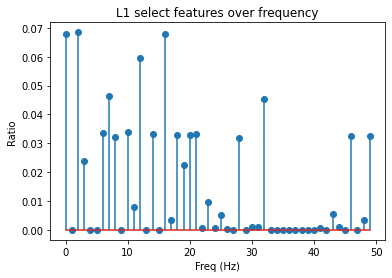

In [19]:
plt.stem(list(range(50)), np.mean(nonzero_features, axis=1))
plt.xlabel('Freq (Hz)')
plt.ylabel('Ratio')
plt.title('L1 select features over frequency')
plt.savefig(os.path.join(RESULT_FOLDER, 'features', 'L1_feature_freq.png'))

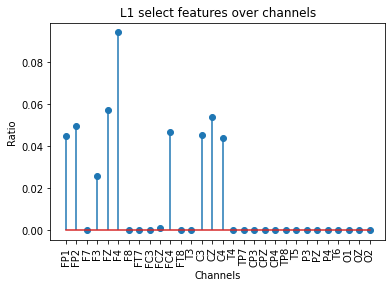

In [20]:
plt.stem(list(range(30)), np.mean(nonzero_features, axis=0))
plt.xlabel('Channels')
plt.xticks(list(range(30)), channels, rotation=90)
plt.ylabel('Ratio')
plt.title('L1 select features over channels')
plt.savefig(os.path.join(RESULT_FOLDER, 'features', 'L1_feature_channels.png'))

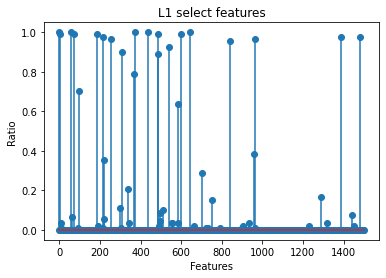

In [21]:
plt.stem(nonzero_features.flatten())
plt.xlabel('Features')
plt.ylabel('Ratio')
plt.title('L1 select features')
plt.savefig(os.path.join(RESULT_FOLDER, 'features', 'L1_features.png'))